## Dask

Dask é uma biblioteca para computação paralela em Python. É composto de duas partes:
- *Big Data collections*: estruturas de dados que utilizam Numpy, Pandas or *iterators*, aplicando-os para ambientes distribuídos e utilizando técnicas para carregamento e processamento de grandes quantidades de dados;
- *Dynamic task scheduling*: escalonador que realiza a execução paralela e distribuída das estruturas existentes em Dask.

![im](https://docs.dask.org/en/stable/_images/dask-overview.svg)
Imagem: [Dask.org](https://docs.dask.org/en/stable/)




In [2]:
from time import sleep

Como abordagem inicial, definiremos duas funções. Nelas, é adicionado um tempo de processamento extra de 1 segundo.

```python
#Incremento e adição
def inc_ser(x):
    print('.', end='')
    sleep(1)
    return x+1

def add_ser(x,y):
    print('.', end='')
    sleep(1)
    return x+y
```

In [82]:
#Incremento e adição
def inc_ser(x):
    print('.', end='')
    sleep(1)
    return x+1

def add_ser(x,y):
    print('.', end='')
    sleep(1)
    return x+y


Definidas as funções, realizaremos o cálculo de da seguinte operação e observaremos o tempo de exeução:
```python
%%time
x = inc_ser(10)
y = inc_ser(20)
z = add_ser(x,y)
print()
```

In [24]:
%%time

x = inc_ser(1)
y = inc_ser(2)
z = add_ser(x,y)
print()

...
CPU times: user 10.8 ms, sys: 4.14 ms, total: 15 ms
Wall time: 3.01 s


Aqui, é esperado que tome um tempo de 3 segundos, visto que para cada incremento é aguardado 1 segundo, acrescido de 1 segundo da operação de soma.

Uma importante função no dask é o método `delayed`. Observe seu uso a seguir.

```python
import dask
from dask import delayed
```

In [5]:
import dask
from dask import delayed

A função `delayed` é preparada para que seja usada como um *python decorator*, podendo ser aplicada a qualquer função.

```python
#Incremento e adição realizado utilizando delayed
@delayed
def inc(x):
    print('.', end='')
    sleep(1)
    return x+1

@delayed
def add(x,y):
    print('.', end='')
    sleep(1)
    return x+y
```

In [28]:
#Incremento e adição realizado utilizando delayed
@delayed
def inc(x):
    print('.', end='')
    sleep(1)
    return x+1

@delayed
def add(x,y):
    print('.', end='')
    sleep(1)
    return x+y

Em seguida, execute a chamada às funções modificadas com o uso do `delayed`:

```python
%%time
x = inc(10)
y = inc(20)
z = add(x,y)
print()
```

In [29]:
%%time

x = inc(10)
y = inc(20)
z = add(x,y)
print()



CPU times: user 854 µs, sys: 0 ns, total: 854 µs
Wall time: 789 µs


Observemos que o código retorna imediamente. Isso porque o cálculo não foi realmente executado. Apenas foi criado o grafo DAG com as operações. Inclusive, podemos visualizar o grafo:

```python
z.visualize()
```

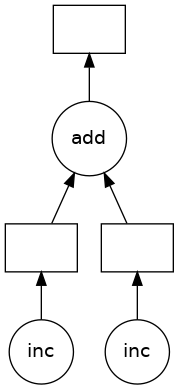

In [30]:
z.visualize()

Observe que as operações `inc` estão no mesmo nível, indicando que serão executadas em paralelo. Seus resultados serão passados à operação `add`.

Precisamos explicitar que a computação será realizada, com o método `.compute()`.

```python
z.compute()
```

In [38]:
%%time
result = z.compute()
print()
print(result)

...
32
CPU times: user 7.94 ms, sys: 6.39 ms, total: 14.3 ms
Wall time: 2.01 s


Agora aplicaremos estas mesmas comparações utilizando valores de uma lista.

In [34]:
%%time
values = list(range(10,25))
print(values)
results = []
for x in values:
    y = inc_ser(x)
    results.append(y)
    
total = sum(results)
print()
print(total)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
...............
270
CPU times: user 36.3 ms, sys: 10.3 ms, total: 46.6 ms
Wall time: 15 s


In [83]:
%%time
results = []
for x in values:
    y = inc(x)
    results.append(y)
soma = delayed(sum)(results)

CPU times: user 1.41 ms, sys: 68 µs, total: 1.48 ms
Wall time: 1.31 ms


Visulizemos o DAG gerado:
```python
soma.visualize()
```

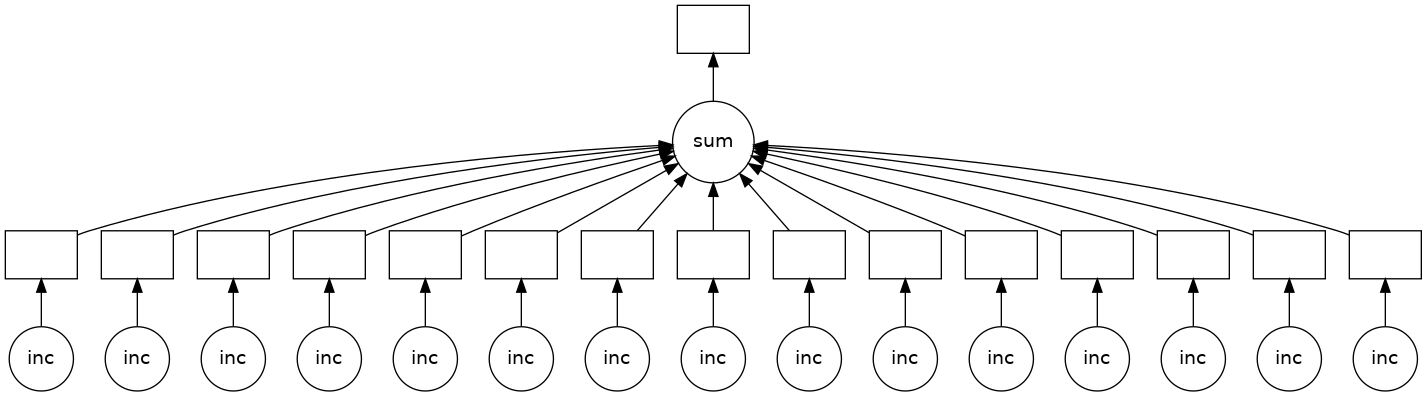

In [84]:
soma.visualize()

Vamos calcular e observar o tempo necessário para o processamento.
```python
%%time
result = soma.compute()
print()
print(result)
```

In [85]:
%%time
result = soma.compute()
print()
print(result)


270
CPU times: user 833 ms, sys: 156 ms, total: 989 ms
Wall time: 4.07 s


### Dask client

Podemos instanciar na máquina local o escalonador Dask, ao executar `Client` sem parâmetros:

```python
from dask.distributed import Client
client = Client()
```

In [73]:
from dask.distributed import Client
client = Client()

Após instanciar o escalonador, podemos acessar seu *dashboard* na porta `8787`. Para tal, acesse:

[http://localhost:8787](http://localhost:8787)


CPU times: user 5.07 ms, sys: 548 µs, total: 5.62 ms
Wall time: 24 ms


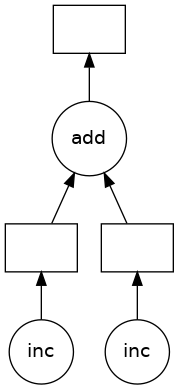

In [75]:
%%time
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x,y)
z.visualize()

Observando o *dashboard* do escalonador, execute o método `.compute()`:

```python
%%time
z.compute()
```

In [79]:
%%time
z.compute()

5

Execute novamente teste anterior:

```python
%%time
values = list(range(10,25))
results = []
for x in values:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
total.visualize()
```

CPU times: user 72.5 ms, sys: 20.3 ms, total: 92.8 ms
Wall time: 659 ms


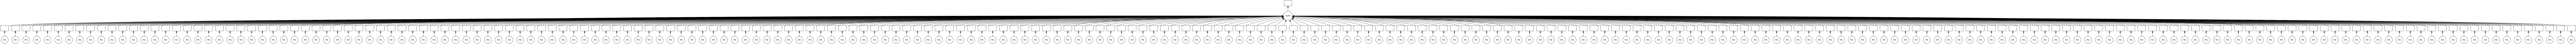

In [97]:
%%time
values = list(range(10,250))
results = []
for x in values:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
total.visualize()

Novamente, execute o método `.compute()` observando o *dashboard*: 

```python
%%time
total.compute()
```

In [94]:
%%time
total.compute()

CPU times: user 397 ms, sys: 75.1 ms, total: 472 ms
Wall time: 2.07 s


270

É possível também configurar a quantidade de *threads* que serão utilizadas para o processamento.

Primeiro, fecharemos o escalonador alocado previamente:

```python
client.close()
```

Em seguida, alocaremos um novo escalonador, definindo um novo número de *threads*:

```python
client = Client(n_workers=8)
```

In [ ]:
client.close()

In [ ]:
client = Client(n_workers=8)

Atualize a página do *dashboard*, para que sejam acessadas informações refentes à nova instância do escalonador. Após atualizar a página, calcule novamente a soma dos valores na lista e observe o tempo de execução.

```python
%%time
print(total.compute())
```

In [96]:
%%time
print(total.compute())

270
CPU times: user 416 ms, sys: 80.5 ms, total: 497 ms
Wall time: 2.06 s


In [87]:
client.close()

.......................................

In [88]:
client = Client(n_workers=8)

CPU times: user 9.24 ms, sys: 4.13 ms, total: 13.4 ms
Wall time: 58.9 ms


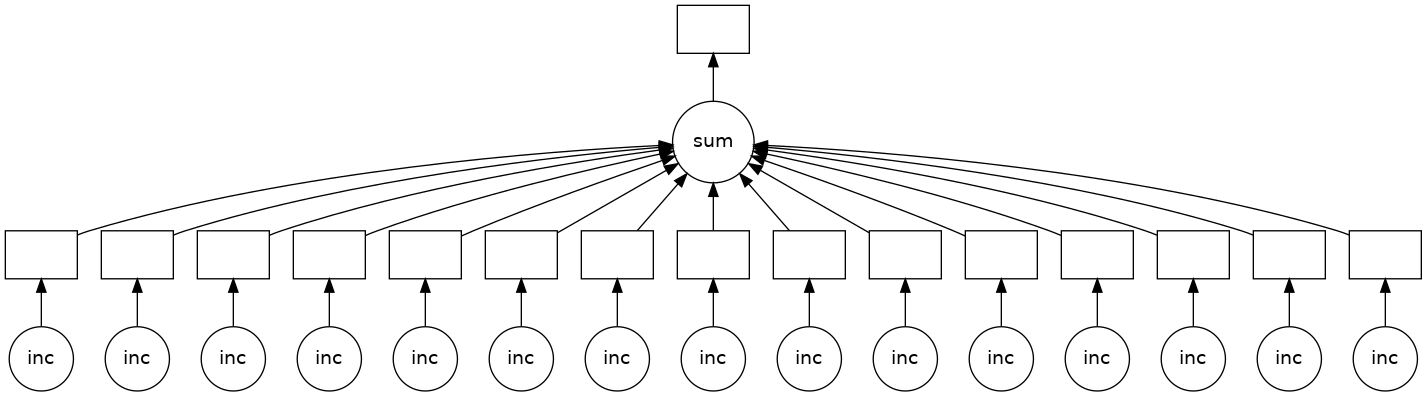

In [90]:
%%time
values = list(range(10,25))
results = []
for x in values:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
total.visualize()

In [98]:
%%time
total.compute()

CPU times: user 6.9 s, sys: 1.37 s, total: 8.28 s
Wall time: 30.2 s


31320

Como exemplo, execute utilizando uma quantidade maior de elementos:

```python
%%time
values = list(range(250))
results = []
for x in values:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print(total.compute())
```

In [99]:
%%time
values = list(range(250))
results = []
for x in values:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print(total.compute())

31375
CPU times: user 6.86 s, sys: 1.31 s, total: 8.17 s
Wall time: 32.2 s


## Referências

- [Dask. Scale the Python tools you love.](https://docs.dask.org/en/stable/)  
- [BOCHMAN, D. Dask: Machine Learning & Data Science Open-source Spotlight. Youtube.](https://www.youtube.com/watch?v=Alwgx_1qsj4&t=755s)